# Convex Minimization Example
This notebook demonstrates how to solve the convex minimization problem in the proposed algorithm.

In [1]:
import numpy as np
import cvxpy as cp

In [2]:
# Setup
ACT_DIM = 2 # action space dimensions
ETA = 1e-8 # used to enforce strict inequality

beta = cp.Parameter() # (> 1) constraint on maximum policy ratio

# safe policy (cvxpy parameters)
mu_safe = cp.Parameter(ACT_DIM)
sigma_safe = cp.Parameter(ACT_DIM, pos=True)

# task policy (cvxpy parameters)
mu_task = cp.Parameter(ACT_DIM)
sigma_task = cp.Parameter(ACT_DIM, pos=True)

# projected policy (cvxpy variables)
mu_proj = cp.Variable(ACT_DIM)
sigma_proj = cp.Variable(ACT_DIM, pos=True)

In [3]:
# Problem definition
objective_dcp = cp.Minimize(-2*cp.sum(cp.log(sigma_proj)) +  cp.sum_squares(sigma_proj/sigma_task) + cp.sum_squares((mu_proj - mu_task)/sigma_task))

constraints_dcp = []

constraint_1_dcp = sigma_proj + ETA <= sigma_safe
constraints_dcp.append(constraint_1_dcp)

sum_term_dcp = 0    # we define the sum term like this so that we can use quad_over_lin and thus allow the problem to be DCP (standard quotient operator is not DCP)
for i in range(0, ACT_DIM):
    sum_term_dcp += cp.quad_over_lin(mu_proj[i] - mu_safe[i],cp.square(sigma_safe[i]) - cp.square(sigma_proj[i]))   # note that numerator gets squared (which we want)

constraint_2_dcp = cp.sum(cp.log(sigma_safe)) - cp.sum(cp.log(sigma_proj)) + (1/2)*sum_term_dcp <= cp.log(beta)
constraints_dcp.append(constraint_2_dcp)

prob_dcp = cp.Problem(objective_dcp, constraints_dcp)

# Check problem is DCP
CHECK_DPP = False
print(objective_dcp.is_dcp(dpp=CHECK_DPP))
print(constraint_1_dcp.is_dcp(dpp=CHECK_DPP))
print(constraint_2_dcp.is_dcp(dpp=CHECK_DPP))
print(prob_dcp.is_dcp(dpp=CHECK_DPP))

True
True
True
True


In [4]:
# Generate examples
beta.value = 1.1 # (> 1) constraint on maximum policy ratio

STRAY_FACTOR = 0.05 # factor on how far the task policy strays from the safe policy

# safe policy
mu_safe.value = np.random.randn(ACT_DIM)
sigma_safe.value = np.random.exponential(size=ACT_DIM) # > 0

# task policy
mu_task.value = mu_safe.value + STRAY_FACTOR*np.random.randn(ACT_DIM) # put task policy mean somewhere fairly close to safe policy mean
sigma_task.value = sigma_safe.value - np.minimum(STRAY_FACTOR*sigma_safe.value*np.random.exponential(size=ACT_DIM),sigma_safe.value-ETA)  # put task policy stdev somewhere fairly close to but less than safe policy stdev (and > 0)

In [5]:
# Solve problem
result = prob_dcp.solve()
print(mu_safe.value, sigma_safe.value)
print(mu_task.value, sigma_task.value)
print(mu_proj.value, sigma_proj.value)

[0.46542142 0.1511575 ] [1.09342264 0.49916695]
[0.52169365 0.11696709] [0.98159105 0.4821729 ]
[0.50336615 0.14232152] [1.01787082 0.49263555]


/home/jacques/miniconda3/envs/cvxpy_env/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain.py:237: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


In [6]:
# Additional variables/parameters for DPP
# safe policy (cvxpy parameters)
sigma_safe_inv = cp.Parameter(ACT_DIM, pos=True) # 1/sigma_safe
sigma_sigma_safe = cp.Parameter(ACT_DIM, pos=True) # sigma_safe^2

# task policy (cvxpy parameters)
sigma_task_inv = cp.Parameter(ACT_DIM, pos=True) # 1/sigma_task
mu_sigma_task = cp.Parameter(ACT_DIM, pos=True) # mu_task/sigma_task
mu_sigma_sigma_task = cp.Parameter(ACT_DIM, pos=True)   # mu_task/(sigma_task)^2

# sum term (cvxpy variables)
mu_safe_var = cp.Variable(ACT_DIM)   # mu_safe
sigma_sigma_safe_var = cp.Variable(ACT_DIM, pos=True)   # sigma_safe^2

In [7]:
# Problem re-definition as DPP
objective_dpp = cp.Minimize(-2*cp.sum(cp.log(sigma_proj)) +  cp.sum_squares(cp.multiply(sigma_proj,sigma_task_inv)) + cp.sum_squares(cp.multiply(mu_proj,sigma_task_inv)) - 2*cp.sum(cp.multiply(mu_proj, mu_sigma_sigma_task)) + cp.sum_squares(mu_sigma_task))

constraints_dpp = []

constraint_1_dpp = sigma_proj + ETA <= sigma_safe
constraints_dpp.append(constraint_1_dpp)

sum_term_dpp = 0    # we define the sum term like this so that we can use quad_over_lin and thus allow the problem to be DCP (standard quotient operator is not DCP)
for i in range(0, ACT_DIM):
    sum_term_dpp += cp.quad_over_lin(mu_proj[i] - mu_safe_var[i],sigma_sigma_safe_var[i] - cp.square(sigma_proj[i]))   # note that numerator gets squared (which we want)

constraint_2_dpp = -cp.sum(cp.log(sigma_safe_inv)) - cp.sum(cp.log(sigma_proj)) + (1/2)*sum_term_dpp <= cp.log(beta)
constraints_dpp.append(constraint_2_dpp)

constraint_3_dpp = mu_safe_var == mu_safe
constraints_dpp.append(constraint_3_dpp)

constraint_4_dpp = sigma_sigma_safe_var == sigma_sigma_safe
constraints_dpp.append(constraint_4_dpp)

prob_dpp = cp.Problem(objective_dpp, constraints_dpp)

# Check problem is DPP
CHECK_DPP = True
print(objective_dpp.is_dcp(dpp=CHECK_DPP))
print(constraint_1_dpp.is_dcp(dpp=CHECK_DPP))
print(constraint_2_dpp.is_dcp(dpp=CHECK_DPP))
print(constraint_3_dpp.is_dcp(dpp=CHECK_DPP))
print(constraint_4_dpp.is_dcp(dpp=CHECK_DPP))
print(prob_dpp.is_dcp(dpp=CHECK_DPP))

True
True
True
True
True
True


In [8]:
# Set additional DPP parameters for examples

sigma_safe_inv.value = 1/sigma_safe.value # 1/sigma_safe
sigma_sigma_safe.value = np.square(sigma_safe.value) # sigma_safe^2

# task policy (cvxpy parameters)
sigma_task_inv.value = 1/sigma_task.value # 1/sigma_task
mu_sigma_task.value = mu_task.value/sigma_task.value # mu_task/sigma_task
mu_sigma_sigma_task.value = mu_task.value/np.square(sigma_task.value)   # mu_task/(sigma_task)^2

In [9]:
# Solve problem
result = prob_dpp.solve()
print(mu_safe.value, sigma_safe.value)
print(mu_task.value, sigma_task.value)
print(mu_proj.value, sigma_proj.value)

[0.46542142 0.1511575 ] [1.09342264 0.49916695]
[0.52169365 0.11696709] [0.98159105 0.4821729 ]
[0.50336385 0.14232261] [1.01786904 0.49263522]


In [14]:
import matplotlib.pyplot as plt

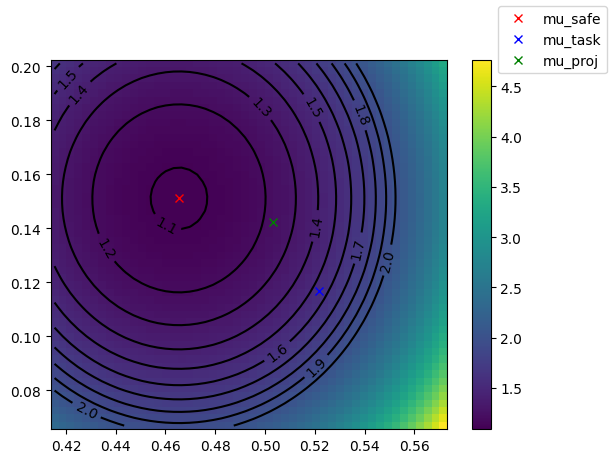

In [57]:
Nx = 50
Ny = 50

mu_x_min = min(mu_safe.value[0],mu_task.value[0],mu_proj.value[0]) - 0.05
mu_x_max = max(mu_safe.value[0],mu_task.value[0],mu_proj.value[0]) + 0.05

mu_y_min = min(mu_safe.value[1],mu_task.value[1],mu_proj.value[1]) - 0.05
mu_y_max = max(mu_safe.value[1],mu_task.value[1],mu_proj.value[1]) + 0.05

mu_x = np.linspace(mu_x_min,mu_x_max,Nx)
mu_y = np.linspace(mu_y_min,mu_y_max,Ny)

policy_ratio = np.zeros((Ny,Nx))

for i in range(0,Nx):
    for j in range(0,Ny):
        policy_ratio[j][i] = np.prod(np.multiply(sigma_safe.value/sigma_proj.value,np.exp(1/2*(np.square(mu_x[i] - mu_safe.value[0]) + np.square(mu_y[j] - mu_safe.value[1]))/(np.square(sigma_safe.value) - np.square(sigma_proj.value)))))

fig, ax = plt.subplots()
im = ax.pcolormesh(mu_x,mu_y,policy_ratio)
fig.colorbar(im)
cs = ax.contour(mu_x,mu_y,policy_ratio, levels=[1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0], colors='k')
ax.clabel(cs, inline=True, fontsize=10)
ax.plot(mu_safe.value[0],mu_safe.value[1],'rx',label="mu_safe")
ax.plot(mu_task.value[0],mu_task.value[1],'bx',label="mu_task")
ax.plot(mu_proj.value[0],mu_proj.value[1],'gx',label="mu_proj")
fig.legend()
plt.show()

In [ ]:
# Failed attempt (is not DCP)

alpha = cp.Variable(ACT_DIM, pos=True) # slack variable used to make problem DCP
log_mu_difference = cp.Variable(ACT_DIM, pos=True) # slack variable used to make problem DCP

objective = cp.Minimize(-2*cp.sum(cp.log(sigma_proj)) +  cp.sum_squares(sigma_proj/sigma_task) + cp.sum_squares((mu_proj - mu_task)/sigma_task))
constraints = []
constraint_1 = sigma_proj + eta <= sigma_safe
constraints.append(constraint_1)
# constraint_2 = cp.exp(1/2*cp.square(mu_proj - mu_safe)/(cp.square(sigma_safe) - cp.square(sigma_proj))) <= beta*sigma_proj/sigma_safe
# constraint_2 = cp.sum(cp.log(sigma_safe)) - cp.sum(cp.log(sigma_proj)) + (1/2)*cp.sum(cp.square(mu_proj-mu_safe)) <= cp.log(beta)
constraint_2 = cp.sum(cp.log(sigma_safe)) - cp.sum(cp.log(sigma_proj)) + (1/2)*cp.sum(alpha) <= cp.log(beta) # need slack variable alpha to handle the summands of the sum term
constraints.append(constraint_2)
# constraint_3 = 2*cp.log(mu_proj - mu_safe) - cp.log(cp.square(sigma_safe) - cp.square(sigma_proj)) <= cp.log(alpha)
constraint_3 = 2*log_mu_difference - cp.log(cp.square(sigma_safe) - cp.square(sigma_proj)) <= cp.log(alpha) # need to add slack variable log_mu_difference to make DCP (convex <= concave)
constraints.append(constraint_3)
constraint_4 = mu_proj - mu_safe <= cp.exp(log_mu_difference) # not DCP because we need convex <= concave but the RHS is convex (taking logs leads to a similar problem)
constraints.append(constraint_4)
# constraints = [cp.prod(cp.exp(1/2*cp.square(mu_proj - mu_safe)/(cp.square(sigma_safe) - cp.square(sigma_proj)))) <= beta*cp.prod(sigma_proj/sigma_safe), sigma_proj + eta <= sigma_safe]
prob = cp.Problem(objective, constraints)

print(objective.is_dcp())
print(constraint_1.is_dcp())
print(constraint_2.is_dcp())
print(constraint_3.is_dcp())
print(constraint_4.is_dcp())